# Business Context

Customer lifetime value (CLV) is the total worth of a customer to a company over the length of their relationship. In practice, this “worth” can be defined as revenue, profit, or other metrics of an analyst’s choosing.


CLV is an important metric to track for two reasons. First, the totality of a company’s CLV over its entire customer base gives a rough idea of its market value. Thus, a company with a high total CLV will appear attractive to investors. Second, a CLV analysis can guide the formulation of customer acquisition and retention strategies. For example, special attention could be given to high-value customers to ensure that they stay loyal to the company.


Many CLV models have been developed with different levels of sophistication and accuracy, ranging from rough heuristics to the use of complex probabilistic frameworks. In this blog post series, we delve into one of them: the Beta Geometric Negative Binomial Distribution (BG-NBD) model. This model, developed by Fader, Hardie, and Lee in 2005¹, has been one of the most influential models in the domain, thanks to its interpretability and accuracy.

Intuition about the model can be found in the following [article](https://medium.com/p/d5111cb52dd).

# Lifetimes

In this section, we will explore the use of the `lifetimes` [library](https://lifetimes.readthedocs.io/en/latest/Quickstart.html#basic-frequency-recency-analysis-using-the-bg-nbd-model)

## Data Load

In [1]:
import pandas as pd
from lifetimes.datasets import load_dataset

cdnow_transactions = load_dataset(
    filename='CDNOW_sample.txt', 
    header=None, 
    delim_whitespace=True, 
    names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
    converters={'date': lambda x: pd.to_datetime(x, format="%Y%m%d")}
)

cdnow_transactions.head(5)

,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96
3,4,1,1997-12-12,2,26.48
4,21,2,1997-01-01,3,63.34


## Data Transformation to RFM format

In [2]:
from lifetimes.utils import summary_data_from_transaction_data
rfm = summary_data_from_transaction_data(transactions=cdnow_transactions,
                                         customer_id_col='customer_id',
                                         datetime_col='date',
                                         monetary_value_col = 'amount',
                                         observation_period_end=pd.to_datetime('1997-09-30'),
                                         freq='W')

rfm.head()

,frequency,recency,T,monetary_value
customer_id,,,,
4,2.0,30.0,39.0,22.345
18,0.0,0.0,39.0,0.000
21,1.0,2.0,39.0,11.770
50,0.0,0.0,39.0,0.000
60,0.0,0.0,35.0,0.000


## Train-test split (calibration/observation split)

In [3]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(transactions=cdnow_transactions,
                                                   customer_id_col='customer_id', 
                                                   datetime_col='date',
                                                   calibration_period_end='1998-01-01',
                                                   observation_period_end='1998-06-30' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_id,,,,,
4,3.0,345.0,365.0,0.0,180.0
18,0.0,0.0,362.0,0.0,180.0
21,1.0,12.0,365.0,0.0,180.0
50,0.0,0.0,365.0,0.0,180.0
60,0.0,0.0,334.0,0.0,180.0


## Model fit

In [4]:
from lifetimes import BetaGeoFitter

# instantiation and fitting of BG-NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(rfm['frequency'], 
        rfm['recency'], 
        rfm['T'])

# printing of model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.290936,0.016509,0.258578,0.323294
alpha,6.852094,0.603680,5.668881,8.035306
a,0.665249,0.191428,0.290051,1.040447
b,2.320324,0.803090,0.746267,3.894380


- do train test split and analysis of the test set
- derive business sense

## Model analysis

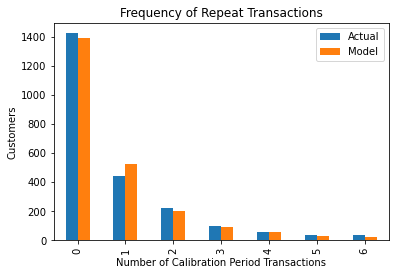

In [5]:
from lifetimes.plotting import plot_period_transactions

_ = plot_period_transactions(bgf) # returns a matplotlib axis object

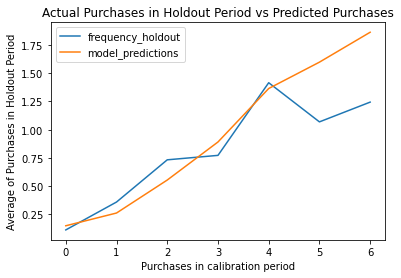

In [6]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases


_ = plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

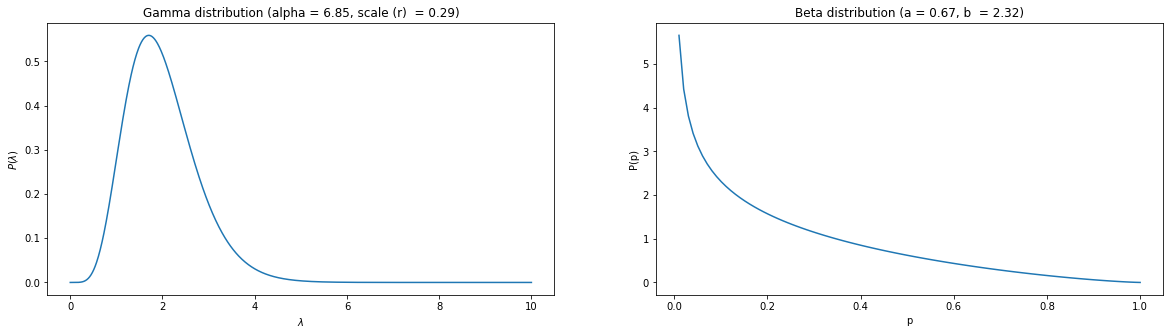

In [7]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

fig, (ax_gamma, ax_beta) = plt.subplots(ncols=2, figsize = (20, 5))

x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=bgf.params_["alpha"], scale=bgf.params_["r"])
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma distribution (alpha = {bgf.params_["alpha"]:.2f}, scale (r)  = {bgf.params_["r"]:.2f})')
ax_gamma.set_xlabel(r'$\lambda$')
ax_gamma.set_ylabel(r'$P(\lambda)$')


x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=bgf.params_["a"], b=bgf.params_["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {bgf.params_["a"]:.2f}, b  = {bgf.params_["b"]:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')
plt.show()

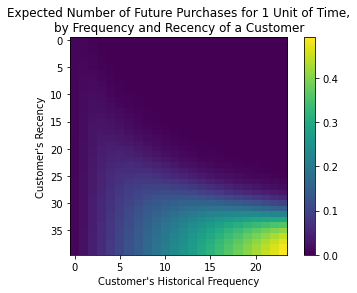

In [8]:
from lifetimes.plotting import plot_frequency_recency_matrix

_ = plot_frequency_recency_matrix(bgf)

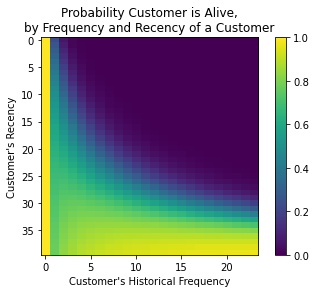

In [9]:
from lifetimes.plotting import plot_probability_alive_matrix

_ = plot_probability_alive_matrix(bgf)

## Model prediction

In [10]:
t = 10 # we will predict the number of future purchases within 10 periods
individual = rfm.iloc[20] # choose one random customer to predict
individual

frequency          3.000000
recency           28.000000
T                 39.000000
monetary_value    25.076667
Name: 226, dtype: float64

In [11]:
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, 
            individual['frequency'], 
            individual['recency'], 
            individual['T'])

0.49535768533644964

In [12]:
bgf.conditional_probability_alive(individual['frequency'], 
                                  individual['recency'], 
                                  individual['T'])

array([0.7247595])

## Business application

In [13]:
rfm["n_purchase_10"] = bgf.predict(10,
                                   rfm['frequency'], 
                                   rfm['recency'], 
                                   rfm['T'])

rfm["alive_prob"] = bgf.conditional_probability_alive(rfm['frequency'], 
                                                      rfm['recency'], 
                                                      rfm['T'])


rfm.head()

,frequency,recency,T,monetary_value,n_purchase_10,alive_prob
customer_id,,,,,,
4,2.0,30.0,39.0,22.345,0.358944,0.751582
18,0.0,0.0,39.0,0.000,0.061587,1.000000
21,1.0,2.0,39.0,11.770,0.079687,0.294425
50,0.0,0.0,39.0,0.000,0.061587,1.000000
60,0.0,0.0,35.0,0.000,0.067292,1.000000


In [14]:
rfm["clv_estimate_10"] = rfm['monetary_value']*rfm['alive_prob']*rfm['n_purchase_10']
rfm.head()

,frequency,recency,T,monetary_value,n_purchase_10,alive_prob,clv_estimate_10
customer_id,,,,,,,
4,2.0,30.0,39.0,22.345,0.358944,0.751582,6.028133
18,0.0,0.0,39.0,0.000,0.061587,1.000000,0.000000
21,1.0,2.0,39.0,11.770,0.079687,0.294425,0.276147
50,0.0,0.0,39.0,0.000,0.061587,1.000000,0.000000
60,0.0,0.0,35.0,0.000,0.067292,1.000000,0.000000


In [15]:
rfm["clv_estimate_10"].describe()

count    2357.000000
mean        4.946841
std        16.579604
min         0.000000
25%         0.000000
50%         0.000000
75%         2.488343
max       265.452256
Name: clv_estimate_10, dtype: float64

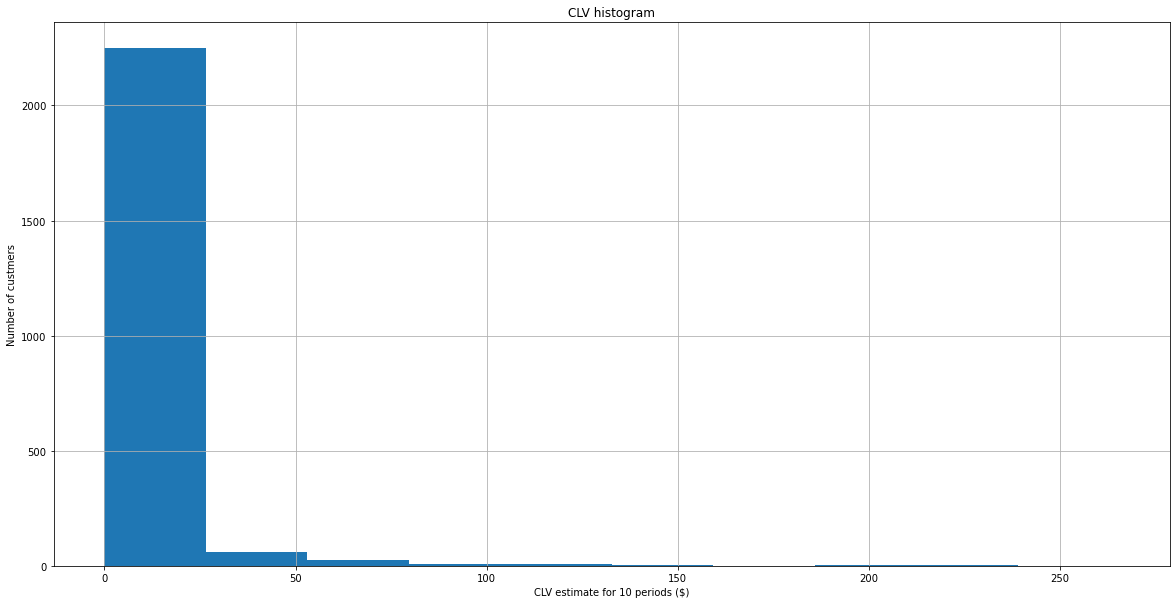

In [16]:
fig, ax = plt.subplots(figsize = (20, 10))

ax = rfm["clv_estimate_10"].hist()
ax.set_title(f'CLV histogram')
ax.set_xlabel(r'CLV estimate for 10 periods ($)')
ax.set_ylabel(r'Number of custmers')

plt.show()

# Bayesian

In [17]:
from pymc3.math import log, exp, where, logsumexp
import pymc3 as pm
import numpy as np


# Extract data for model following notation from Fader/Hardie
N = rfm.shape[0] # number of customers
x = rfm['frequency'].values
t_x = rfm['recency'].values
T = rfm['T'].values


bgnbd_model = pm.Model()
with bgnbd_model:
    
    # Hyperparameters for lambda, i.e. rate of number of transactions
    sigma_r = pm.HalfNormal('sigma_r', 5.)
    sigma_alpha = pm.HalfNormal('sigma_alpha', 5.)
    r = pm.HalfNormal('r', sd=sigma_r)
    alpha = pm.HalfNormal('alpha', sd=sigma_alpha)

    # Hyperparameters for p, i.e. probability of dropout
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    sigma_b = pm.HalfNormal('sigma_b', 5.)
    a = pm.HalfNormal('a', sd=sigma_a)
    b = pm.HalfNormal('b', sd=sigma_b)

    # Gamma prior on purchasing rate parameter lambda
    # Note: per Fader et al, we use r and alpha to parameterize Gamma(lambda)
    lambda_ = pm.Gamma('lambda', alpha=r, beta=alpha, shape=N, testval=np.random.rand(N))
    
    # Beta prior on probabibility of dropout p
    p = pm.Beta('p', alpha=a, beta=b, shape=N, testval=np.random.rand(N))
    
    def logp(x, t_x, T):
        """
        Loglikelihood function for an individual customer's purchasing rate \lambda
        and probability \p of becoming inactive given their 
            - frequency (x)
            - recency (t_x) 
            - time since first purchase (T)
        """    
        delta_x = where(x>0, 1, 0)
        
        A1 = x*log(1-p) + x*log(lambda_) - lambda_*T
        A2 = (log(p) + (x-1)*log(1-p) + x*log(lambda_) - lambda_*t_x)

        A3 = log(exp(A1) + delta_x * exp(A2))
        
        return A3
    
    # Custom distribution for BG-NBD likelihood function
    loglikelihood = pm.DensityDist("loglikelihood", logp, observed={'x': x, 't_x': t_x, 'T': T})


In [18]:
# from Austin Rochford
SEED = 22 # from random.org, for reproducibility

SAMPLE_KWARGS = {
    'chains': 2,
    'draws': 2000,
    'tune': 1000,
    'target_accept': 0.8,
    'random_seed': [
        SEED,
        SEED + 1
    ]
}
with bgnbd_model:
    trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p, lambda, b, a, sigma_b, sigma_a, alpha, r, sigma_alpha, sigma_r]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 203 seconds.
There were 402 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7067017613967037, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


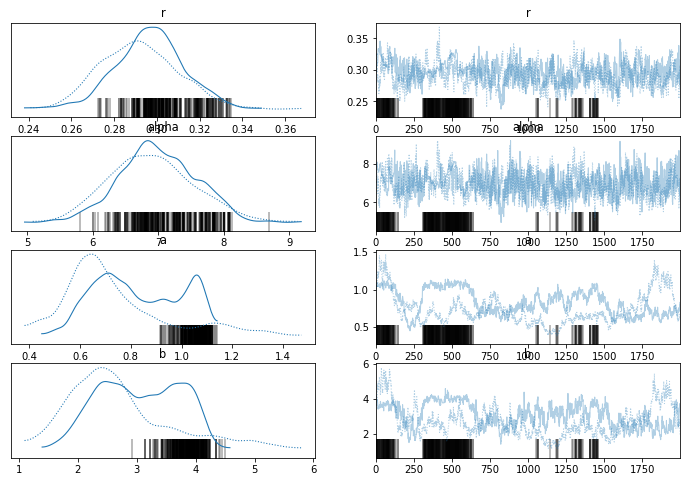

In [19]:
_ = pm.plot_trace(trace, var_names = ["r", "alpha", "a", "b"])